In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [15]:
import sys, os, pathlib
import numpy as np
import scipy as sp
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

Loading ../data/BIOQIC/fem_box2/90/wave.nc
Loading ../data/BIOQIC/fem_box2/90/mre.nc
Loading ../data/BIOQIC/fem_box2/90/mre_mask.nc


<IPython.core.display.Javascript object>


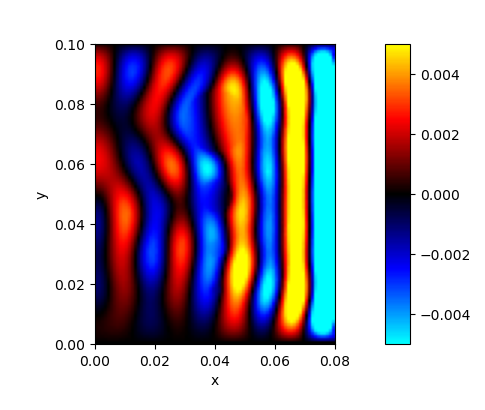

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


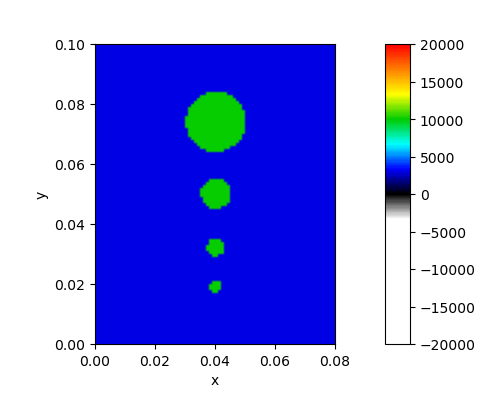

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [10]:
frequency = 90
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box2/', frequency)
example.view('wave', ax_height=3, polar=False, vmax=5e-3)
example.view('mre',  ax_height=3, polar=True,  vmax=20e3)

In [11]:
example.metadata

size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [149]:
u = example.wave
mu = example.mre

N_x, N_y, N_z, N_c = u.shape
N_z = 1
N_x, N_y, N_z

(80, 100, 1)

In [150]:
(N_x * N_y * N_z)

8000

In [151]:
x = example.wave.field.points()
x

array([[0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.001],
       [0.   , 0.   , 0.002],
       ...,
       [0.079, 0.099, 0.007],
       [0.079, 0.099, 0.008],
       [0.079, 0.099, 0.009]])

<IPython.core.display.Javascript object>


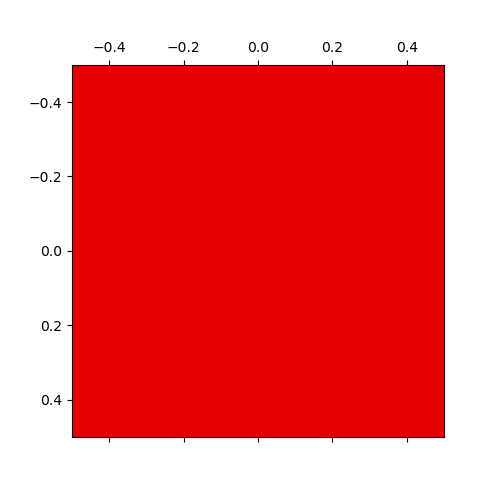

In [152]:
# construct 1D Laplacian matrix

main = np.full(N_z, -6)
ones = np.ones(N_z - 1)

L1 = np.diag(main) + np.diag(ones, 1) + np.diag(ones, -1)
plt.matshow(L1, cmap='seismic_r', vmin=-10, vmax=10)

<IPython.core.display.Javascript object>


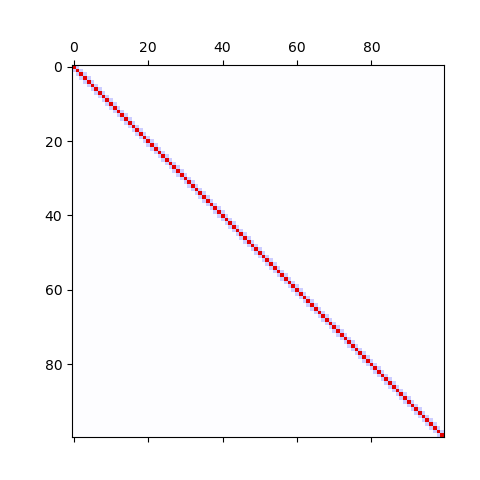

In [153]:
# construct 2D Laplacian matrix

main = [L1 for i in range(N_y)]
ones = np.ones((N_y - 1)*N_z)

L2 = sp.linalg.block_diag(*main) + np.diag(ones, N_z) + np.diag(ones, -N_z)
plt.matshow(L2, cmap='seismic_r', vmin=-10, vmax=10)

<IPython.core.display.Javascript object>


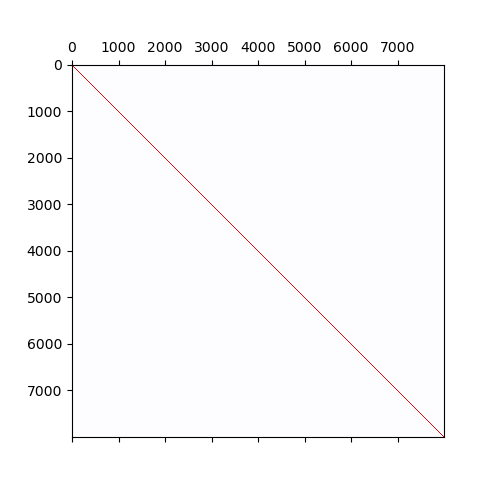

In [154]:
# construct 3D Laplacian matrix

main = [L2 for i in range(N_x)]
ones = np.ones((N_x - 1)*N_y*N_z)

L3 = sp.linalg.block_diag(*main) + np.diag(ones, k=N_y*N_z) + np.diag(ones, k=-N_y*N_z)

plt.matshow(L3, cmap='seismic_r', vmin=-10, vmax=10)

In [160]:
# compare matmul to convolution

nax = np.newaxis
K = np.zeros((3,3,3))
K[1,1,:] += [1,-2,1]
K[1,:,1] += [1,-2,1]
K[:,1,1] += [1,-2,1]

A = np.random.choice([0,1,2,3], (N_x,N_y,N_z))

result1 = sp.ndimage.convolve(A, K, mode='constant')
result2 = (L3 @ A.flatten()).reshape(A.shape).astype(int)

np.linalg.norm(result1 - result2) / np.linalg.norm(result1)

0.0